* Let's make a ship hull using our own customized design space.
* First we define our design variables
    *   At present, these must match the variable names the form parameter system expects
    *   But we are free to give some of them interval bounds of _whatever_ we wish
    *   We are also free to stipulate which rules inter-relate the design variables.
    *   If we choose an infeasible set of starting rule, interval combinations, then
        *   The entire design space is infeasible
        *   Our search program, which is intended to return a single consistent set of almost real valued form parameters (very, very thin interval valued) will instead return a null space.  The zero set, loosely speaking.
        *   This means its time to tweak either the rules, or, more likely, the starting interval parameter bounds, somewhere.  
        *   Common sense typically is enough to get a feasible starting space, but one can get into trouble if one tries to force a tightly constarined space into the system.
        *   Anyway, a workable starting set is used by default below.
* Next a random, yet feasible search will pull a consistent set of form parameters from the space.
    *   This is where the magic of the constraint logic unification together with interval arithmetic shows up.
    *   (This is just about the only place where it is used in this hull design process)
    *   (Intervals, especially together with automatic differentiation, are well know to be capable of far more.)
    *   We ignore most of the interval analysis superpowers and merely have them filter constraints here.  Quite simple in theory.  
    *   The devil, as far as this work goes, is in the details of a self generating rules network.
* Form parameter design (FPD) will take over after at that point
    *   generating first the hull curves
        *   SAC (sectional area curve (the tall one, full volume specified (maybe I should have only specified the $1/2$ volume for reasons to be clear in a second.)))  
        *   DWL (design water line (waterline "outline" of the hull, 1/2 side only))
        *   CProfile (center plane curve - the keel and outline of the centerline of the vessel below the waterline, generally)
    *   Then FPD next tackles the transverse curves 
        *   which match sectional area given by the SAC at the station where the transverse is to be located.
        *   And use the DWL and CProfile curves as end points
        *   More could be specified but right now we are keeping things simple.
    *   Then a set of longitudinal curves are developed.
        *   These will collectively define the B-spline hullform.
        *   These will interpolate the control vertices which make up the transverse curves
        *   First we generate them via simple linear interpolation
        *   Then they are optimized for fairness (and to match parameterization for the surface, but you don't _need_ to know that, I suppose.)
    

In [1]:
import relational_lsplines as rlspline
lp = rlspline.lp # miniKanren - like relational logic, extended for intervals.
ia = rlspline.ia # interval arithmetic class
from relational_lsplines.simple_hull_rules_language import HullGeometryGenerator#, make_hull_rules_net

* We need a designspace
* "make_hull_rules_net" in the above import contains basic rules to make one.  We've commented it out to do things explicitly.
* "HullGeometryGenerator" is a high level search class that runs on top of the language and relational engine.

In [2]:
from relational_lsplines.opt_simple_hull import ShipDesigner

* ShipDesigner contains functions that know how to use most things in relational_lsplines, 
* including how to build a ship hull form via form parameter design.

In [3]:
# this will create a hull rules net using the default rules 
# built into the function "make_hull_rules_net"
hullrulesnet = HullGeometryGenerator(rtype='gauss',verbose=True) 

### Great, what do we have so far??

In [4]:
print hullrulesnet

HullGeometryGenerator, self.rgp.env
rules graph processor
 design space (self.rgp.env) is as follows:




* Not much
* Let's add some rules:

In [5]:

#
#***********************************
# Instantiate the design space variables
#
# as "lp.PStates" objects
# these are the basic nodes of the tiny rules DSL
#
#
# these will be very precisely defined below
# but we will say a few words about them here too.
#

# basic dimensions and volume
lwl = lp.PStates(name='lwl')
bwl = lp.PStates(name='bwl')
draft = lp.PStates(name='draft')
vol = lp.PStates(name='vol')
disp = lp.PStates(name='disp')

#global hull volumetric coefficients
Cb = lp.PStates(name='Cb')
Cp = lp.PStates(name='Cp')

#water plane area and coefficient of water plane
Awp = lp.PStates(name='Awp')
Cwp = lp.PStates(name='Cwp')

#Center plane area and coefficient of center plane
Acp = lp.PStates(name='Acp')
Ccp = lp.PStates(name='Ccp')

#Midship area and coefficient
Amsh = lp.PStates(name='Amsh')
Cmidshp = lp.PStates(name='Cmidshp')

# Longtitudinal center of volume and a coefficient
LCG = lp.PStates(name='LCG')
Clcg = lp.PStates(name='Clcg') #we will define this with a rule

Cbl = lp.PStates(name='Cbl') #beam to length ratio
Cdl = lp.PStates(name='Cdl') #displacement to length ratio

* Now, some rules (relational constraints)

In [6]:
#
#***********************************
# Basic Dimension Relations
"""
#rule: rename vol to disp
"""
disp = disp == vol

"""-----------------------------------------------
#rule: block coefficient
"""
Cb = Cb == vol/(lwl*bwl*draft)


"""-----------------------------------------------
#rule: prismatic coefficient
"""
Cp = Cp == Cb/Cmidshp


"""-----------------------------------------------
#rule: waterplane coefficient
#"""
Cwp = Cwp == Awp/(lwl*bwl)


"""-----------------------------------------------
#rule: Centerplane Coefficient
#"""
Ccp = Ccp == Acp/(lwl*draft)


"""-----------------------------------------------
#rule: midship coefficient
#"""
Cmidshp = Cmidshp == Amsh/(bwl*draft)


"""-----------------------------------------------
#rule: LCG Coefficient, Clcg denotes the fraction of lwl
at which to find the LCG.  (interval valued, remember!)
#"""
LCG = LCG == Clcg*lwl




#
#***********************************
# Flat of water line, center plane, and SAC
# SAC = Sectional Area Curve
#
# These are "hull form curve" "form parameters"
# in the parlance of form parameter design.
#
#
lfwl = lp.PStates(name='lfwl')      #flat water line
lfcp = lp.PStates(name='lfcp')      #flat center plane
lfsac = lp.PStates(name='lfsac')    #flat of SAC



"""-----------------------------------------------
#rule:
    states = (states * (max_height,mid_len,mid_area))  
    mid_area <= Amsh*lfsac
    lfsac = mid_len
    max_height = Amsh
#"""
#lfsac = lfsac <= Cp*vol*ia(.2,.4)/Amsh
lfsac = lfsac <= Cp*vol*ia(.3,.5)/Amsh

#
#***********************************
# Add flat rule to the Database:

hullrulesnet.set_rules(lfsac)
hullrulesnet.rgp.compute_fresh_rules_graph()






#
#***********************************
# Add the above rules to the Database
# like so:
hullrulesnet.set_rules(disp,
                       Cb,
                       Cp,
                       Cwp,
                       Ccp,
                       Cmidshp,
                       LCG)
#***********************************
#
hullrulesnet.rgp.compute_fresh_rules_graph()


* What did we do?

In [7]:
hullrulesnet.print_hull_state()

(disp, [disp])
(None, [None])
(None, [None])
(Amsh, [Amsh])
(vol, [disp])
(Cwp, [Cwp])
(None, [None])
(None, [None])
(Awp, [Awp])
(draft, [draft])
(None, [None])
(lfsac, [lfsac])
(None, [None])
(lwl, [lwl])
(Clcg, [Clcg])
(None, [None])
(Ccp, [Ccp])
(Cmidshp, [Cmidshp])
(Acp, [Acp])
(bwl, [bwl])
(None, [None])
(Cb, [Cb])
(LCG, [LCG])
(Cp, [Cp])


* Not a lot so far - we have not defined any interval values!
* More rules to come...

In [8]:
"""-----------------------------------------------
#rule: beam/Length ratio (to be added)
#"""
Cbl = Cbl == bwl/lwl

"""-----------------------------------------------
#rule: displacement/Length ratio (to be added)
#"""
Cdl = Cdl == vol/lwl
#
#***********************************
# compile to the relational rules base again:
hullrulesnet.set_rules(Cbl,Cdl)
#
"""
#rule: Cbl, the beam to length interval
        is set to some fractional range
"""
Cbl = Cbl == ia(.2,.4)
#
#***********************************
# compile to the relational rules base again:
hullrulesnet.set_rules(Cbl)
hullrulesnet.rgp.compute_fresh_rules_graph()





"""-----------------------------------------------
#rule: RULE: flat of SAC <= lfwl
"""
lfsac = lfsac <= lfwl#*ia(.5,.7) - bad to modify this rule.  why? 
# because we already have a rule for the fraction relating these two
# it's [> lfwl = lfwl <= lfsac*ia(1.0,1.2) <] this guy
#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)

hullrulesnet.rgp.compute_fresh_rules_graph()
lfsac = lfsac == lwl*ia(.01,.25)
#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)

hullrulesnet.rgp.compute_fresh_rules_graph()

"""-----------------------------------------------
#rule: flat of SAC <= lfcp
#"""
lfsac = lfsac <= lfcp


#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)
hullrulesnet.rgp.compute_fresh_rules_graph()



#
#***********************************
# more Flat rules



"""
Do we need these any more?
lfwl = lfwl <= Cp*Awp/bwl


lfcp = lfcp <= Cp*Acp/draft
"""

#rule:  flat of WL FOWL
#lfwl = lfwl <= lfsac*ia(3.0,10.)
lfwl = lfwl == lfsac*ia(3.5,4.)


#rule: flat of CL Keel FOCP
#lfcp = lfcp <= lfsac*ia(2.,2.5)
lfcp = lfcp == lfsac*ia(1.5,2.)


#
#***********************************
# Add flat rules all to the Database:
hullrulesnet.set_rules(lfwl,
                       lfcp)
hullrulesnet.rgp.compute_fresh_rules_graph()




lfcp = lfcp <= lfwl
hullrulesnet.set_rules(lfcp)
hullrulesnet.rgp.compute_fresh_rules_graph()


#
#***********************************
# Set the design space intervals themselves
# not done here.  Using something else to do the same


#
#***********************************
# rule: instantiate Cp with tight limits
Cp = Cp == ia(.6,.75)
hullrulesnet.set_rules(Cp)
hullrulesnet.rgp.compute_fresh_rules_graph()


hullrulesnet.print_hull_state()

(disp, [disp])
(None, [None])
(None, [None])
(Amsh, [Amsh])
(vol, [disp])
(Cwp, [Cwp])
(lfwl, [lfwl])
(None, [None])
(None, [None])
(Awp, [Awp])
(draft, [draft])
(None, [None])
(lfcp, [lfcp])
(lfsac, [lfsac])
(None, [None])
(lwl, [lwl])
(Clcg, [Clcg])
(None, [None])
(Ccp, [Ccp])
(Cmidshp, [Cmidshp])
(Acp, [Acp])
(bwl, [bwl])
(None, [None])
(Cdl, [Cdl])
(Cb, [Cb])
(Cbl, [ia(0.2, 0.4)])
(LCG, [LCG])
(Cp, [ia(0.6, 0.75)])


* Howzza - I may want to break this up in the future.  We could have started with numbers!
### We could have started with "numbers" - but I chose to start with relationships
* This completes a small ship hull design rules net.
*  Let's add some design space intervals to see what we can see...

In [9]:
lwl = lwl == ia(80.,130.) #how about a design with some ballpark near 100 "meter" hull?
#lwl is the allowable range of the design space length along the waterline
# this is the only measure of "global length" we will use in these simplistic examples.


draft = draft == ia(12.,21.) #design space for draft - an interval ranging from 12 to 21 length units.

bwl = bwl == ia(22.,34.) #design space for breadth 
#(NOTE!: full width required expected here for the form parameter code - to come after design space narrowing.)

vol = vol == ia(1000.,25000.) #volume of the ship hull 
#(not worrying about density of fluid this second - yes our weightless vessel has a waterline.... I am sorry!)

LCG = LCG == ia(30.,70.) #longitudinal center of volume #better to specify this closely with an 
# interval coefficient.  See Clcg.

Clcg = Clcg == ia(.45,.49) #ratio of LCG to lwl - see rule above.  This interval allows the LCG to be in a 
# narrow range around midship.

#"""
hullrulesnet.print_hull_state()
hullrulesnet.set_rules(lwl,
                      draft,
                      bwl,
                      vol,
                      LCG,
                      Clcg)



Cb = Cb == ia(0.3,0.65)  # block coeficient allowable range of the design space. (maybe a good osv is not to fat?)

Cmidshp = Cmidshp == ia(0.94,.99) #full midsection desired


Cwp = Cwp == ia(.81,.95) #water plane coefficient

Ccp = Ccp == ia(.76,.85) #centerplane coefficient

hullrulesnet.set_rules(Cb,
                       Cmidshp,
                       Cwp,
                       Ccp)

## See rules above for the definitions of these rules.  Here we mostly just assign some 
## reasonable interval ranges for our design space.
##

(disp, [disp])
(None, [None])
(None, [None])
(Amsh, [Amsh])
(vol, [disp])
(Cwp, [Cwp])
(lfwl, [lfwl])
(None, [None])
(None, [None])
(Awp, [Awp])
(draft, [draft])
(None, [None])
(lfcp, [lfcp])
(lfsac, [lfsac])
(None, [None])
(lwl, [lwl])
(Clcg, [Clcg])
(None, [None])
(Ccp, [Ccp])
(Cmidshp, [Cmidshp])
(Acp, [Acp])
(bwl, [bwl])
(None, [None])
(Cdl, [Cdl])
(Cb, [Cb])
(Cbl, [ia(0.2, 0.4)])
(LCG, [LCG])
(Cp, [ia(0.6, 0.75)])


* Just a few more rules

In [10]:
"""-----------------------------------------------
#rule: beam/Length ratio
#"""
Cbl = Cbl == bwl/lwl

"""-----------------------------------------------
#rule: displacement/Length ratio 
#"""
Cdl = Cdl == vol/lwl
#
#***********************************
# compile to the relational rules base again:
hullrulesnet.set_rules(Cbl,Cdl)
#
"""
#rule: Cbl, the beam to length interval
        is set to some fractional range
"""
Cbl = Cbl == ia(.2,.4)
#
#***********************************
# compile to the relational rules base again:
hullrulesnet.set_rules(Cbl)
hullrulesnet.rgp.compute_fresh_rules_graph()





"""-----------------------------------------------
#rule: RULE: flat of SAC <= lfwl
"""
lfsac = lfsac <= lfwl#*ia(.5,.7) - bad to modify this rule.  why? 
# because we already have a rule for the fraction relating these two
# it's [> lfwl = lfwl <= lfsac*ia(1.0,1.2) <] this guy
#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)

hullrulesnet.rgp.compute_fresh_rules_graph()
lfsac = lfsac == lwl*ia(.01,.25)
#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)

hullrulesnet.rgp.compute_fresh_rules_graph()

"""-----------------------------------------------
#rule: flat of SAC <= lfcp
#"""
lfsac = lfsac <= lfcp


#
#***********************************
# Add rule to the Database:
hullrulesnet.set_rules(lfsac)
hullrulesnet.rgp.compute_fresh_rules_graph()



#
#***********************************
# more Flat rules



"""
Do we need these any more?
lfwl = lfwl <= Cp*Awp/bwl


lfcp = lfcp <= Cp*Acp/draft
"""

#rule:  flat of WL FOWL
#lfwl = lfwl <= lfsac*ia(3.0,10.)
lfwl = lfwl == lfsac*ia(3.5,4.)


#rule: flat of CL Keel FOCP
#lfcp = lfcp <= lfsac*ia(2.,2.5)
lfcp = lfcp == lfsac*ia(1.5,2.)


#
#***********************************
# Add flat rules all to the Database:
hullrulesnet.set_rules(lfwl,
                       lfcp)
hullrulesnet.rgp.compute_fresh_rules_graph()




lfcp = lfcp <= lfwl
hullrulesnet.set_rules(lfcp)
hullrulesnet.rgp.compute_fresh_rules_graph()


#
#***********************************
# Set the design space intervals themselves
# not done here.  Using something else to do the same


#
#***********************************
# rule: instantiate Cp with tight limits
Cp = Cp == ia(.6,.75)
hullrulesnet.set_rules(Cp)
hullrulesnet.rgp.compute_fresh_rules_graph()



In [11]:
hullrulesnet.print_hull_state()

(disp, [ia(11911.68, 25000.0)])
(None, [None])
(None, [None])
(Amsh, [ia(248.16, 706.86)])
(vol, [ia(11911.68, 25000.0)])
(Cwp, [ia(0.81, 0.95)])
(lfwl, [ia(2.8, 38.8888888889)])
(None, [None])
(None, [None])
(Awp, [ia(1425.6, 4199.0)])
(draft, [ia(12.0, 21.0)])
(None, [None])
(lfcp, [ia(1.2, 22.2222222222)])
(lfsac, [ia(0.8, 11.1111111111)])
(None, [None])
(lwl, [ia(80.0, 130.0)])
(Clcg, [ia(0.45, 0.49)])
(None, [None])
(Ccp, [ia(0.76, 0.85)])
(Cmidshp, [ia(0.94, 0.99)])
(Acp, [ia(729.6, 2320.5)])
(bwl, [ia(22.0, 34.0)])
(None, [None])
(Cdl, [ia(91.6283076923, 312.5)])
(Cb, [ia(0.564, 0.65)])
(Cbl, [ia(0.2, 0.4)])
(LCG, [ia(36.0, 63.7)])
(Cp, [ia(0.6, 0.691489361702)])


### This is the end of the hard work.  Now we just need the magic words.

* ShipDesigner knows most of the magic words.
* We just need to set it going.
* The work was to specify the design space for the algorithms to draw from.
* The relational rules engine will find feasible hull design parameter sets.
  *   Think of a single hull design as a point in the high dimensional form parameter space
  *   The relational rules engine is presently configured to search out such feasible points at random.
  *   The idea is that if it can generate a hull "at random" then it is "pretty robust".
* Form parameter ship hull design will turn those into a hull

In [12]:
# Ship Designer encapsulated the magic words for us:
SD = ShipDesigner(design_space=hullrulesnet)

*  First use ShipDesigner to find a single design 
   *  by randomly picking "thin" interval form parameters one form parameter at a time
   *  These choices are then propogated through the constraint network we built above.
   *  Narrowing the feasible domain.
   *  Once arc consistency reaches a fixed point, it's time to pick another thin form parameter.
   *  Repeat until all form parameters are thin
   *  Then procede to form parameter generation of the geometry!

In [13]:
# By random (thin) interval parameter selection, 
# narrow the design space into a "thin" design
# via constraint propogation of each selection through the network,
#
# -each time a parameter is selected and propogated, 
# the design space is narrowed via Arc Consistency
#


SD.bare_hull_random_design_selection_new()

beginning tree search
:
count :  0
using  gauss  random sequence 
x =  0.244366583318
done  bwl => ia(24.9323689998,24.9324289998)
x =  0.987007506036
done  Amsh => ia(515.264543652,515.264603652)
x =  0.626250138327
done  Cmidshp => ia(0.987770923916,0.987830923916)
x =  0.230343901161
done  vol => ia(24793.0674118,24793.0674718)
x =  0.0625947370593
done  lwl => ia(80.0125098625,80.0125698625)
x =  0.40976698578
done  Cb => ia(0.594000502916,0.594060502916)
x =  0.00384936311813
done  draft => ia(20.9210045203,20.9210645203)
x =  0.133874801215
done  Cp => ia(0.601339490078,0.601399490078)
x =  0.302972474442
done  lfsac => ia(3.92404004477,3.92410004477)
x =  0.00543609436492
done  disp => ia(24793.0673822,24793.0674422)
x =  0.899131269812
done  Cwp => ia(0.935848377774,0.935908377774)
x =  0.0970215008213
done  Awp => ia(1866.93864181,1866.93870181)
x =  0.14122178745
done  Ccp => ia(0.77267996087,0.77273996087)
x =  0.284662971431
done  Acp => ia(1293.4524954,1293.4525554)
x =  0

In [14]:
# check to see if any intervals remain 
# these would represent interval valued constraints
# we do not go there in this version.  
# though a design space paver would be nice...
#
SD.design_space.get_thick_list()

[]

*  The list of thick interval valued constraints is empty.  (This was almost gauranteed by our search, but it is good to check.)
*  The design space is now narrowed to a single design.
*  Time to generate hull curves,
*  Generate transverse curves
*  Generate longitdinal space curves which interpolate them
*  And loft the hull surface
*  All curves will be optimized for fairness and constrained so as to meet the requirements stipluated by our new design parameter set.

In [15]:
# initiate form parameter design:

SD.make_bare_hull()


 make_bare_hull: 
Create a bare hull B-spline surface from
 a thin set of hull constraints 
 via FPD 

------------------------------------------

SAC
Doing first stage SAC solve


/home/luke/anaconda2/lib/python2.7/site-packages/relational_lsplines/automatic_differentiation.py:343: RuntimeWarning: invalid value encountered in divide
  return ad(np.sqrt(dummy.value) , 0.5*dummy.grad/np.sqrt(dummy.value),
/home/luke/anaconda2/lib/python2.7/site-packages/relational_lsplines/automatic_differentiation.py:345: RuntimeWarning: invalid value encountered in divide
  (0.5*np.transpose(dummy.grad)*0.5*dummy.grad/np.sqrt(dummy.value)))/dummy.value


Doing second stage SAC solve
------------------------------------------

cLProfile

 hull_from_simple_designspace: compute_cLProfile (Keel Profile)
Doing first stage CPkeel solve

 hull_from_simple_designspace : split_cLProfile 

utility function: match_curve
cLProfile split
only splitting fwd portion
now fixing parameterizatin of aft portion
fixing  2
fixing  3
fixing  4
fixing  5
fixing  6
utility function: match_curve
------------------------------------------

DWL

 hull_from_simple_designspace: compute_DWL (Design Waterline)
DWL to end at transom 
Doing first stage DWL solve
Done with primary DWL generation  


Done with aft (not) DWL - transverse - generation 


------------------------------------------

 compute_midship_section
midship stage 1 solve:
midship stage 2 solve:
midship curve done
midship curve done
flat of side curve done
flat of side curve done
flat of side curve done
------------------------------------------

 hull_from_simple_designspace: compute_bow_fairing_cur

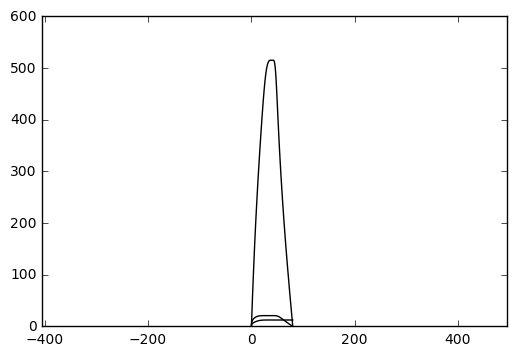

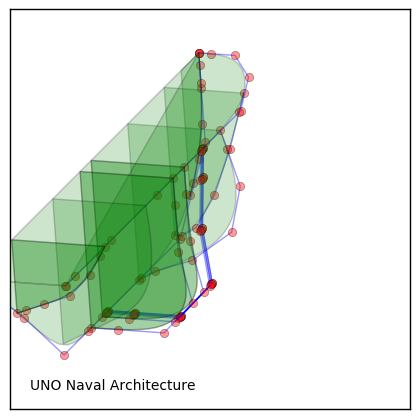

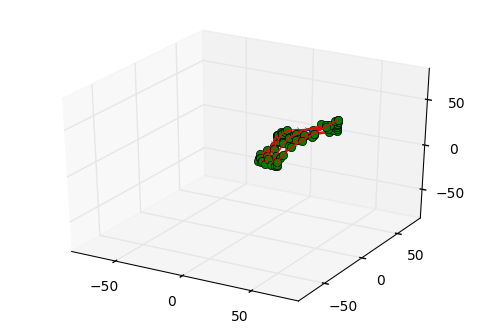

In [16]:
#TODOs spotted above:
#-eliminate stage 1 SAC building - it is often problimatic and counts for nothing
# DWL and CProfile curve split/match runs into problems to often
# these are random designs, but by choosing more logical design workflows
# to build the curves some of this churn can be eliminated.  After all
# the slit/match process amounts to re-parameterization of the split curves
# to match knot vectors.
#
# Also, it might make SAC look better to have it specify the half volume,
# since after all, that is what it is used for.
# it would be nice not to have to remember to divide everything by two 
# when finding transverse volumes.
# and the sec. area. curve might "look better" to boot?
#

# hmm what do we have now?
#
SD.plot_bare_hull_results()

*  Unfortunately Jupyter is not letting me zoom in and rotate the plots..